## 1 - Implementing the paper - Our Baseline

### 1.1- Loading Image Paths

In [1]:
import os
!pip install drive
import drive
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### 1.1.x Preparing Colab for running the code

In [2]:
!pip install fastai==2.4

  Using cached fastai-2.4-py3-none-any.whl.metadata (9.8 kB)
  Using cached fastcore-1.3.29-py3-none-any.whl.metadata (16 kB)
INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.10,>=1.7.0 (from fastai) (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch<1.10,>=1.7.0


The following will download about 20,000 images from COCO dataset. Notice that **we are going to use only 8000 of them** for training. Also you can use any other dataset like ImageNet as long as it contains various scenes and locations.

In [3]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [4]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
torch.manual_seed(123)
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10_000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


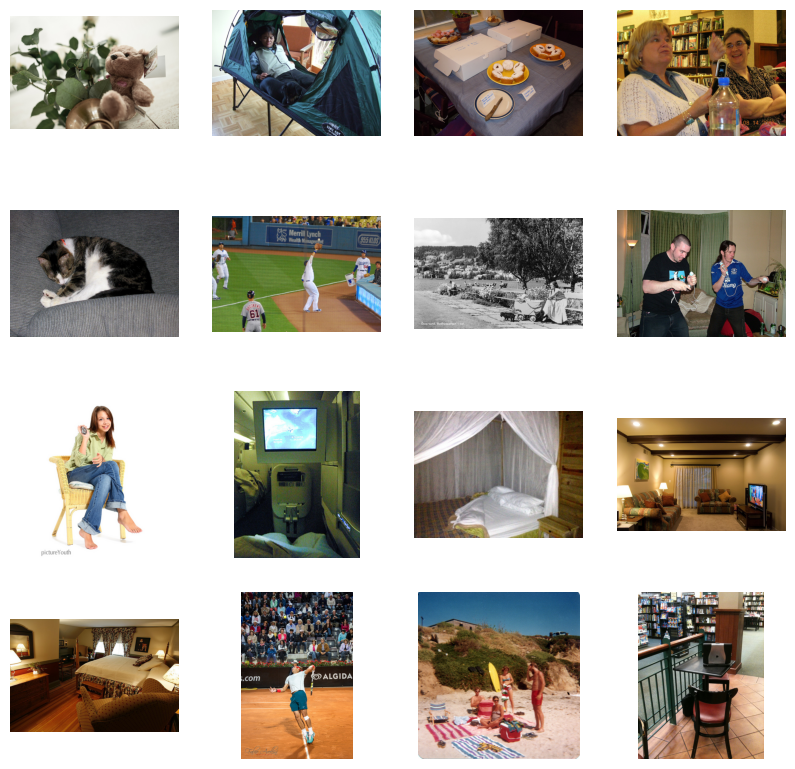

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

### 1.2- Making Datasets and DataLoaders

I hope the code is self-explanatory. I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then I'm making the data loaders.

In [5]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [6]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(batch_size=16,paths=val_paths, split='val') # the original version has 16 in batches

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))
data=torch.cat((Ls, abs_), dim=1)

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


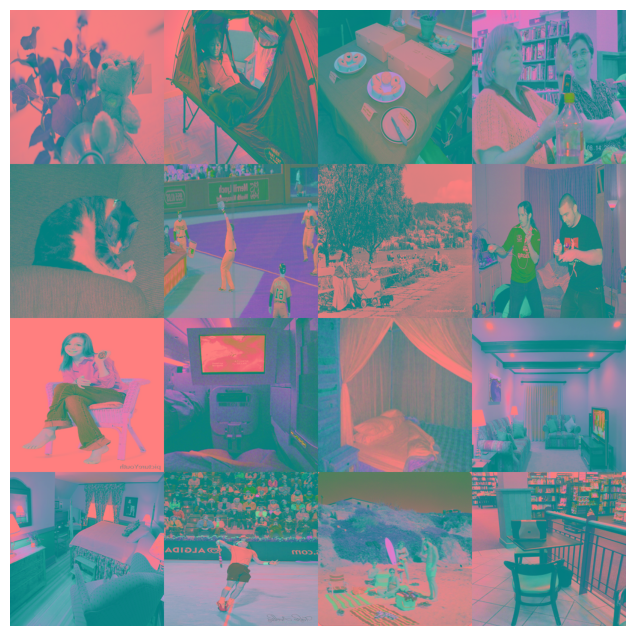

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch

def display_lab_images_in_grid(lab_images, nrow=4):
    """
    Display a batch of Lab images on a grid without spaces.

    Parameters:
    - lab_images (Tensor): A batch of images in Lab format, shape (batch_size, 3, 256, 256).
    - nrow (int): Number of images per row.
    """
    # Normalize the Lab images for display (Lab channels range varies)
    lab_images = (lab_images - lab_images.min()) / (lab_images.max() - lab_images.min())

    # Create a grid of Lab images
    grid_img = torchvision.utils.make_grid(lab_images, nrow=nrow, padding=0)

    # Display the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert to (H, W, C) for display
    plt.axis('off')  # Remove axis for cleaner display
    plt.show()

display_lab_images_in_grid(data)


### 1.3- Generator proposed by the paper

In [7]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

### 1.4- Discriminator

In [8]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

### 1.5- GAN Loss

In [9]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

In [10]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class brings together all the previous parts and implements a few methods to take care of training our complete model. Let's investigate it.

In the __init__ we define our generator and discriminator using the previous functions and classes we defined and we also initialize them with init_model function which I didn't explain here but you can refer to my GitHub repository to see how it works. Then we define our two loss functions and the optimizers of the generator and discriminator.

The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class.

Then, we first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss.
Now, we can train the generator. In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. As I mentioned earlier, we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [11]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100., gan_mode='vanilla'):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode=gan_mode).to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

These functions were nor included in the explanations of the TDS article. These are just some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [12]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=False, save_path=None, epoch=None):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"{save_path}/colorization_epoch_{epoch}.png")

def log_results(loss_meter_dict, save_path=None, epoch=None):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

    if save_path:
        os.makedirs(save_path, exist_ok=True)

        row = [epoch] + [loss_meter.avg for loss_meter in loss_meter_dict.values()]

        csv_file = os.path.join(save_path, "training_loss.csv")
        with open(csv_file, mode='a', newline='') as f:
            writer = csv.writer(f)
            if f.tell() == 0:  # if new file, write header
                writer.writerow(['Epoch'] + list(loss_meter_dict.keys()))
            writer.writerow(row)


As you can see, although this baseline model has some basic understanding of some most common objects in images like sky, trees, … its output is far from something appealing and it cannot decide on the color of rare objects. It also displays some color spillovers and circle-shaped mass of color (center of first image of second row) which is not good at all. So, it seems like that with this small dataset we cannot get good results with this strategy. **Therefore, we change our strategy!**

## 2- A new strategy - the final model

### 2.1- Using a new generator

Building a U-Net with a ResNet backbone is not something trivial so I'll use fastai library's Dynamic U-Net module to easily build one. You can simply install fastai with pip or conda (if you haven't already at the beginning of the tutorial). Here's the link to the [documentation](https://docs.fast.ai/).

#### Update Jan 8th, 2022: <br>
You need to install fastai version 2.4 for the following lines code to run w/o errors.
If you have already installed it using the cell in the beginning of the tutorial, you don't need to install it here again.
<br><br><br>

In [13]:
# pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [14]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet_model = resnet18(pretrained=True)
    body = create_body(resnet_model, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

That's it! With just these few lines of code you can build such a complex model easily. create_body function loads the pretrained weights of the ResNet18 architecture and cuts the model to remove the last two layers (GlobalAveragePooling and a Linear layer for the ImageNet classification task). Then, DynamicUnet uses this backbone to build a U-Net with the needed output channels (2 in our case) and with an input size of 256.

### 2.2 EVALUATION METRICS

 Calculating different metrics her - FID, L

In [16]:
!pip install torchmetrics
!pip install lpips
!pip install torcheval
!pip install torch-fidelity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.3 MB/s eta 0:00:00


In [17]:
from torchmetrics.image.fid import FrechetInceptionDistance

def convert_to_uint8(images):
    """
    Convert a batch of RGB images from [0, 1] range to [0, 255] range with uint8 data type.

    Parameters:
    - images (torch.Tensor): Tensor of shape (batch_size, 3, height, width) with values in [0, 1].

    Returns:
    - torch.Tensor: Tensor of shape (batch_size, 3, height, width) with values in [0, 255] and dtype uint8.
    """
    images_255 = images * 255.0  # Scale to [0, 255]
    images_clamped = torch.clamp(images_255, 0, 255)  # Ensure no values exceed [0, 255]
    images_uint8 = images_clamped.type(torch.uint8)  # Convert to uint8
    return images_uint8


def log_fid(net_G, val_dl, device, model_name, save_filename):
    fid = FrechetInceptionDistance(feature=2048, reset_real_features=True, normalize=False, input_img_size=(3, 256, 256))
    #net_G.eval()

    with torch.no_grad():  # Disable gradient calculation
        for data in tqdm(val_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            #preds = model(L)
            real_rgb_batch=torch.from_numpy(lab_to_rgb(L, ab)).permute(0,3,1,2)
            #fake_rgb_batch=torch.from_numpy(lab_to_rgb(L, preds)).permute(0,3,1,2)
            fid.update(convert_to_uint8(real_rgb_batch), real=True)
            fid.update(convert_to_uint8(real_rgb_batch), real=False) # maknuti ovu liniju
            #fid.update(convert_to_uint8(fake_rgb_batch), real=False)
    fid_score = fid.compute()

    if save_filename:
        result_data = {
            'Model Name': model_name,
            'Metric Name': 'FID',
            'Metric Value': fid_score.item()
        }
        df = pd.DataFrame([result_data])

        if os.path.exists(save_filename):
            df.to_csv(save_filename, mode='a', header=False, index=False)
        else:
            df.to_csv(save_filename, mode='w', header=True, index=False)
    return fid_score.item()

In [18]:
import torch
import torchmetrics
import lpips
import torcheval
from torchvision.models.inception import inception_v3
import torch.nn.functional as F

def get_psnr(real_rgb, fake_rgb, data_range=1.0, device='cuda'):
    """
    Calculates the PSNR between real and fake images on GPU.

    Parameters:
    - real_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), real images.
    - fake_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), fake images.
    - data_range (float): Range of pixel values (255 for [0, 255] images, 1.0 for [0, 1] images).
    - device (str): The device to run the computation on ('cpu' or 'cuda').

    Returns:
    - float: PSNR value.
    """
    psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=data_range).to(device)
    psnr_value = psnr_metric(fake_rgb, real_rgb).item()
    return psnr_value


def get_ssim(real_rgb, fake_rgb, data_range=1.0, device='cuda'):
    """
    Calculates the SSIM between real and fake images on GPU.

    Parameters:
    - real_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), real images.
    - fake_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), fake images.
    - data_range (float): Range of pixel values (255 for [0, 255] images, 1.0 for [0, 1] images).
    - device (str): The device to run the computation on ('cpu' or 'cuda').

    Returns:
    - float: SSIM value.
    """
    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=data_range).to(device)
    ssim_value = ssim_metric(fake_rgb, real_rgb).item()
    return ssim_value


## constant, only to be defined once (were downloading the alexnet)
LPIPS_FN = lpips.LPIPS(net='alex').to(device)

def get_lpips(real_rgb, fake_rgb, device='cuda'):
    """
    Calculates the LPIPS score between real and fake images on GPU.

    Parameters:
    - real_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), real images.
    - fake_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), fake images.
    - device (str): The device to run the computation on ('cpu' or 'cuda').

    Returns:
    - float: LPIPS score.
    """
    real_rgb = real_rgb.to(device)
    fake_rgb = fake_rgb.to(device)


    lpips_score = LPIPS_FN(real_rgb, fake_rgb)
    avg_lpips = lpips_score.mean().item()

    return avg_lpips


def get_colorfulness(real_rgb, fake_rgb, device='cuda'):
    """
    Calculates the colorfulness metric for a batch of fake RGB images on the specified device.

    Parameters:
    - real_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), real images (unused but here for consistency with other functions)
    - fake_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), fake images.
    - device (str): The device to run the computation on ('cpu' or 'cuda').

    Returns:
    - float: Average colorfulness score for the batch.
    """
    fake_rgb = fake_rgb.to(device)

    R = fake_rgb[:, 0, :, :]
    G = fake_rgb[:, 1, :, :]
    B = fake_rgb[:, 2, :, :]

    rg = R - G
    yb = 0.5 * (R + G) - B

    sigma_rg = torch.std(rg, dim=(1, 2))
    sigma_yb = torch.std(yb, dim=(1, 2))
    mu_rg = torch.mean(rg, dim=(1, 2))
    mu_yb = torch.mean(yb, dim=(1, 2))

    sigma_rgyb = torch.sqrt(sigma_rg**2 + sigma_yb**2)
    mu_rgyb = torch.sqrt(mu_rg**2 + mu_yb**2)

    colorfulness = sigma_rgyb + 0.3 * mu_rgyb
    return colorfulness.mean().item()

## CONSTANT
INCEPTION = inception_v3(pretrained=True, transform_input=False).to(device)
INCEPTION.eval()

def get_is(real_rgb, fake_rgb, device='cuda'):
    """
    Calculates the IS metric for a batch of fake RGB images on the specified device.

    Parameters:
    - real_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), real images (unused but here for consistency with other functions)
    - fake_rgb (Tensor): Tensor of shape (batch_size, 3, height, width), fake images.
    - device (str): The device to run the computation on ('cpu' or 'cuda').

    Returns:
    - float: Average Inception Score (IS) for the batch.
    """
    generated_images = fake_rgb.to(device)

    with torch.no_grad():
        generated_features = INCEPTION(generated_images.view(-1,3,256,256))

    generated_features = generated_features.view(generated_features.size(0), -1)
    p = F.softmax(generated_features, dim=1)

    kl = p * (torch.log(p) - torch.log(torch.tensor(1.0/generated_features.size(1)).to(device)))
    kl = kl.sum(dim=1)

    return kl.mean().item()



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 190MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [ ]:
### just to test each of the metrics, well call them with the same batch of the val_loader
val_batch=next(iter(val_dl))
L, ab = val_batch['L'].to(device), val_batch['ab'].to(device)
image_batch=torch.from_numpy(lab_to_rgb(L, ab)).permute(0,3,1,2)
print(image_batch.shape)
print(torch.min(image_batch))

torch.Size([16, 3, 256, 256])
tensor(0.)


In [ ]:
print(f"calculated lpips score: {get_lpips(image_batch, image_batch)}")
print(f"calculated psrn score: {get_psnr(image_batch, image_batch)}") # AttributeError: module 'torchvision.transforms.functional' has no attribute 'psnr'
print(f"caluculated ssim score: {get_ssim(image_batch, image_batch)}")
print(f"caluculated colorfulness score: {get_colorfulness(image_batch, image_batch)}")
print(f"caluculated IS score: {get_is(image_batch, image_batch)}")

calculated lpips score: 0.0
calculated psrn score: inf
caluculated ssim score: 1.0
caluculated colorfulness score: 0.1865314394235611
caluculated IS score: 5.438488006591797


In [ ]:
import os
import pandas as pd

def get_metric(model, val_loader, metric, save_filename=None, model_name=None):
    """
    Calculates the given metric for the given model on the given validation dataloader, prints,
    and saves the results into a CSV file with the given filename.

    Parameters:
    - model: The PyTorch model to evaluate.
    - val_loader: DataLoader for the validation dataset.
    - metric: A callable that computes the metric given predictions and targets.
    - save_filename: The filename to save the results (optional). The file will be saved in the current working directory.
    - model_name: Name of the model for identification in the CSV.
    """
    model.eval()
    metric_meter = AverageMeter()

    with torch.no_grad():  # Disable gradient calculation
        for data in tqdm(val_loader):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = model(L)
            real_rgb_batch=torch.from_numpy(lab_to_rgb(L, ab)).permute(0,3,1,2)
            fake_rgb_batch=torch.from_numpy(lab_to_rgb(L, preds)).permute(0,3,1,2)
            calc = metric(real_rgb_batch, fake_rgb_batch)
            metric_meter.update(calc, L.size(0))

    print(f"smlkm {metric_meter.avg:.5f}")


    # Average metric over all batches
    final_metric = metric_meter.avg
    print(f"Final {metric.__name__}: {final_metric:.4f}")

    if save_filename:
        result_data = {
            'Model Name': model_name,
            'Metric Name': metric.__name__[4:].upper(),
            'Metric Value': final_metric
        }
        df = pd.DataFrame([result_data])

        if os.path.exists(save_filename):
            df.to_csv(save_filename, mode='a', header=False, index=False)
        else:
            df.to_csv(save_filename, mode='w', header=True, index=False)

    return final_metric

# Example usage:
# get_metric(model, val_loader, psnr, "metrics_results.csv", "ResNet_UNet")


With this simple function, we pretrain the generator for 20 epochs and then we save its weights. This will take an hour on Colab. In the following section, we will use this model as the generator for our GAN and train the whole network as before:

In [ ]:
# first we will load all of out models - unet_30, vanilla_gan_20, lsgan_20, vanilla_low_lambda
unet_G_30 = build_res_unet(n_input=1, n_output=2, size=256)
unet_G_30.load_state_dict(torch.load("res18-unet_epoch_30.pt", map_location=device))

vanilla_net_G = build_res_unet(n_input=1, n_output=2, size=256)
vanilla_net_G.load_state_dict(torch.load("vanilla_net_G.pt", map_location=device))

ls_gan_net_G = build_res_unet(n_input=1, n_output=2, size=256)
ls_gan_net_G.load_state_dict(torch.load("ls_gan_net_G.pt", map_location=device))

vanilla_low_lambda_net_G = build_res_unet(n_input=1, n_output=2, size=256)
vanilla_low_lambda_net_G.load_state_dict(torch.load("v_low_lambd_net_G.pt", map_location=device))

ls_gan_30_net_G = build_res_unet(n_input=1, n_output=2, size=256)
ls_gan_30_net_G.load_state_dict(torch.load("net_G_lsgan_epoch_30.pt", map_location=device))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-24-e02c3de1af64>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via th

<All keys matched successfully>

In [ ]:
!pip install --upgrade --force-reinstall torch-fidelity

  Using cached torch_fidelity-0.3.0-py3-none-any.whl.metadata (2.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.3 MB/s eta 0:00:00
Using cached torch_fidelity-0.3.0-py3-none-any.whl (37 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:

In [ ]:
models=[unet_G_30, vanilla_net_G, ls_gan_net_G, vanilla_low_lambda_net_G, ls_gan_30_net_G]  ## when passing GAN, make sure to pass the Gnerator model beacuse pf the logic in get_metric
model_names=["unet_30", "vanilla_gan_20", "ls_gan_20", "vanilla_20_low_lambda", "ls_gan_30"]


for i, model in enumerate(models):
  for metric in [get_colorfulness, get_psnr, get_ssim, get_lpips, get_is]:
      get_metric(model, val_dl, metric, "coco_validation_2k.csv", model_names[i])

for i, model in enumerate(models):
      log_fid(model, val_dl,'cuda', model_names[i],  "coco_validation_2k.csv")


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: 

  0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 24 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 93 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 37 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 40 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarni

  0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 30 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 72 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


  0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 18 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 29 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 23 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 35 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-17-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 25 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


In [ ]:
def ground_truth(x):
  return x

log_fid(ground_truth, val_dl, 'cuda', 'GROUND_TRUTH',  "coco_validation_2k.csv")

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:02<00:00, 38.7MB/s]


  0%|          | 0/125 [00:00<?, ?it/s]

-9.611857194613549e-07

### Evaluating on different datasets!

In [ ]:
import kagglehub

# Download latest version
landscape_path = kagglehub.dataset_download("arnaud58/landscape-pictures")

print("Path to dataset files:", landscape_path)

landscape_paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
torch.manual_seed(123)
np.random.seed(123)
paths_landscape = np.random.choice(landscape_paths, 500, replace=False) # choosing 500 images randomly
print(len(paths_landscape))

landscape_dl = make_dataloaders(batch_size=32,paths=paths_landscape, split='val') # the original version has 16 in batches

data = next(iter(landscape_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(landscape_dl))

Path to dataset files: /root/.cache/kagglehub/datasets/arnaud58/landscape-pictures/versions/2


In [ ]:
import kagglehub

# Download latest version
rooms_streets_path = kagglehub.dataset_download("mikhailma/house-rooms-streets-image-dataset")

print("Path to dataset files:", rooms_streets_path)

In [ ]:
import kagglehub

# Download latest version
city_path = kagglehub.dataset_download("shravankumar9892/image-colorization")

print("Path to dataset files:", city_path)

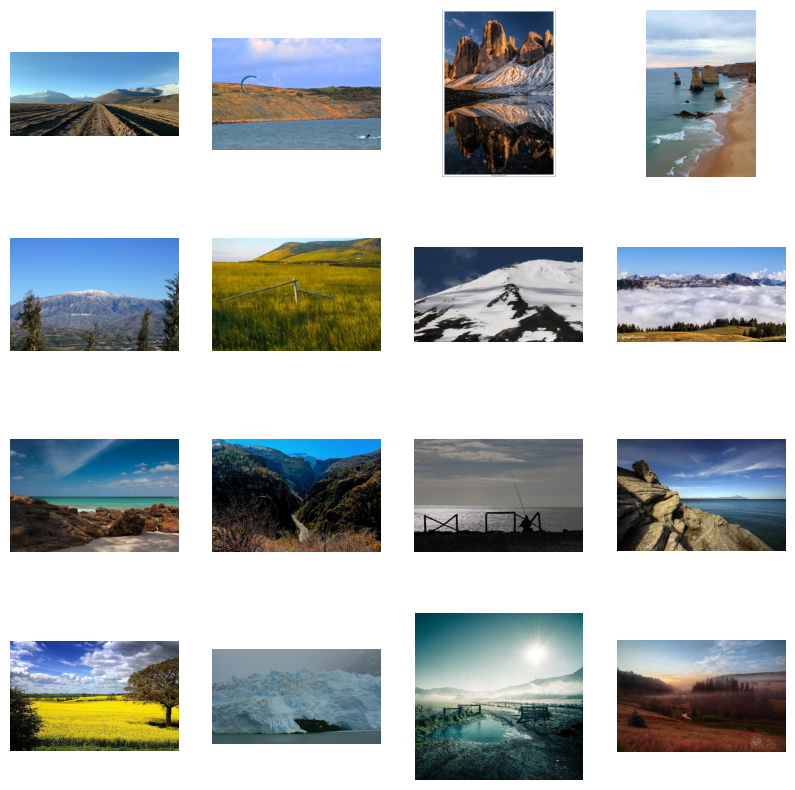

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), paths_landscape):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

## visualising results


In [21]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/evaluacija/'
os.listdir(folder_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['v_low_lambd_net_G.pt', 'net_G_lsgan_20.pt']

In [23]:
lsgan_20=build_res_unet(n_input=1, n_output=2, size=256)
lsgan_20.load_state_dict(torch.load(f"{folder_path}/net_G_lsgan_20.pt", map_location=device))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-23-739ece9bd221>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

<All keys matched successfully>

In [60]:
data_iter=iter(val_dl)
example_data=next(data_iter)
example_data=next(data_iter)
rgb_example=lab_to_rgb(example_data['L'], example_data['ab'])
print(rgb_example.shape)
prediction=lsgan_20(example_data['L'].to(device))
print(prediction.shape)
prediction_batch=lab_to_rgb(example_data['L'].to(device), prediction.detach())
print(prediction_batch.shape)


(16, 256, 256, 3)
torch.Size([16, 2, 256, 256])
(16, 256, 256, 3)


<ipython-input-12-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-12-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-12-b62f20584657>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


In [56]:
import matplotlib.pyplot as plt
import cv2

def display_image_batches(batch1, batch2):
    """
    Displays two batches of images side by side in a 4x4 grid layout.

    Parameters:
    - batch1 (numpy.ndarray): A batch of 16 images with shape (16, height, width, channels),
                              where `height`, `width`, and `channels` correspond to the image dimensions
                              (e.g., 28x28 for grayscale images or 32x32x3 for RGB images).
    - batch2 (numpy.ndarray): A batch of 16 images with the same shape as `batch1`.

    The function will display the first batch in a 4x4 grid on the left and the second batch on the right.
    The images in each batch are shown in a 4x4 grid (16 images per batch).
    """
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))

    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(batch1[i*4 + j])
            axes[i, j].axis('off')  # Hide axis

            axes[i, j+4].imshow(batch2[i*4 + j])
            axes[i, j+4].axis('off')  # Hide axis

    plt.tight_layout(pad=0)
    plt.show()


def display_batch_in_grayscale_and_rgb(batch):
    """
    Displays a single batch of images with the first half in grayscale and the second half in RGB.

    Parameters:
    - batch (numpy.ndarray): A batch of RGB images with shape (batch_size, height, width, 3).
    """
    batch_gray = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in batch])

    fig, axes = plt.subplots(4, 8, figsize=(15, 8))

    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(batch_gray[i * 4 + j], cmap='gray')
            axes[i, j].axis('off')  # Hide axis

            axes[i, j + 4].imshow(batch[i * 4 + j])
            axes[i, j + 4].axis('off')  # Hide axis

    plt.tight_layout(pad=0)
    plt.show()


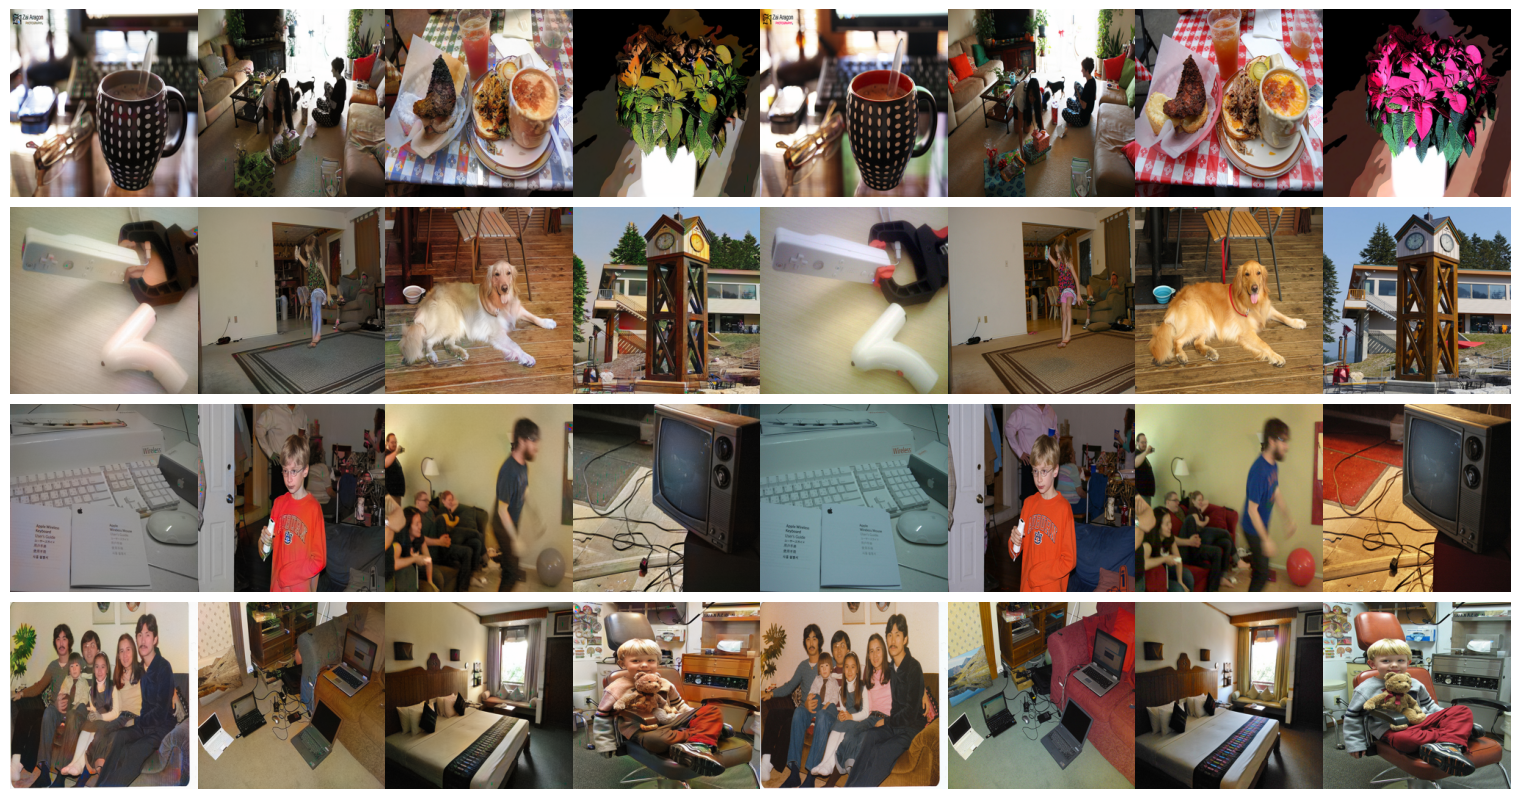

In [61]:
display_image_batches(prediction_batch, rgb_example)

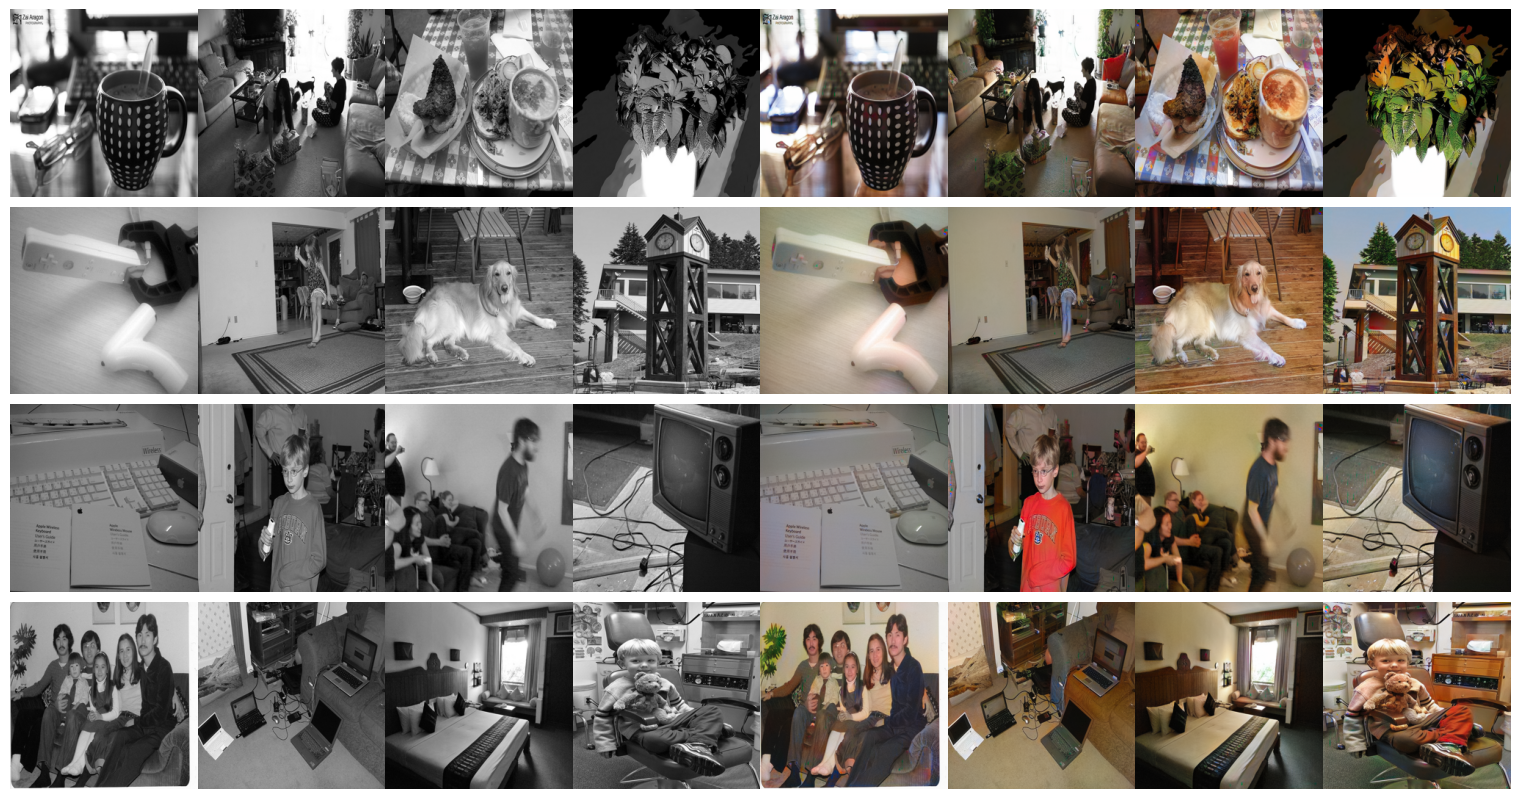

In [62]:
display_batch_in_grayscale_and_rgb(prediction_batch)